# HPC in Finance - Performance Overview

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, special
from IPython.display import Image

: 

## Assignment 1: Improved Black Scholes
European Call and Put options using Black Scholes formula. Compute the greeks: 
- delta
- gamma
- vega
- theta
- rho

Image(url= "greeks_table.png", width=400, height=400)



### Steps to log into *Midway* Server
- `ssh -Y siebenschuh@midway3.rcc.uchicago.edu`
- pw: as on okta for CNetID (requires push)
Run
- `module avail`
- `module list`
- `module load intel/2022.0`

Use Use Intel complier (icc) to build the program
- `icc -O2 assignment1.cpp`

Then run the file 
- `./assignment1`

### Exact steps for Assignment 1
1. Generate random input values
2. Measure current time, <font color='red'>t1</font>
3. Price 1 million call, put options and greeks. Do NOT write results to console. Writing the results to console will slow down your program.  This step will be used to evaluate how fast your program ran.
4. Measure current time, <font color='red'>t2</font>
5. Write time taken (t2-t1) to console.
6. Using the functions used in step 3, price call, put and greeks for the following 3 options. Write results to console. Results will be used to verify correctness of your program

    (a)   S = 100; K = 100; r = 0.03; v = 0.3, T = 1
    
    (b)   S = 110; K= 100; r = 0.03, v= 0.3; T = 1
    
    (c)   S = 90; K = 100; r = 0.03; v = 0.3; T = 1
    
### A List of Improvements (in order of relative effectiveness)

#### Improvements 
- **Reducing the number of function calls from standard library**: exponential `std::exp()`, logarithmic `std::log()`, Gaussian error function `std::erf()`, and even power function `std::exp()` turned out to be major consumers of walltime. Miniming the call count drastically improved runtime. In particular, constants such as `std::sqrt(2.0)` slow the code down unnecessarily and are easily replaced. However, replacing functions by hand was not trivial (an online C implementation of the Gaussian error function was slower than `std::erf` even when `inline`d). Going forward, it is worth exploring how equivalent function definitions in `Boost` perform. ~1/3 of the runtime savings. 
- **put-call parity**: speeds computation up as it requires less evaluations of expensive functions (e.g. `std::exp()` and `std::log()`. In turn, it is a consequence of the former bullet point. Regardless, it shows that domain knowledge (economics) and mathematical rigor (BS prices must be arbitrage-free; in turn, put-call parity must hold) is invaluable when designing fast and correct software
- **global variables**: defining global variables and manipulating them through functions (without handing them over as arguments, neither value nor reference) turned out to be a fruitful improvement. In combination with replacing `std::` functions much runtime was saved.
- switching from `std::vector<double> S_vec(N)` to C arrays `double S_vec[N]` (that were globally defined) sped things up majorly.  
- `inline`ing function didn't seem to change runtime at all. In fact, it is unclear if the compiler even considers the keyword when optimizing.
- changing `if` conditions from `>` to `!=` (when possible) and switching the order of conditions helped a little. 

#### Neutral
- `double` to `float`: virtually no change although `float` is `32 bit` (IEEE 754 single precision) while `64 bit` IEEE 754 double precision. Likely explanation provided on [stackoverflow](https://stackoverflow.com/questions/4584637/double-or-float-which-is-faster#:~:text=Floats%20are%20faster%20than%20doubles,half%20the%20space%20per%20number.) and [quora](https://www.quora.com/Is-double-faster-than-float-in-C)
    - x86 processors have 80bit registers (neither float nor double). In turn, float and double are both extended (for free) to an internal 80-bit format, so both have the same performance (except for cache footprint / memory bandwidth
    - memory bandwith can be a bottleneck but doesn't have to be
    
#### Adverse
- Replacing the Gaussian quantile function was non-trivial. An idea was to piecewise approximate the quantile function and iterate the cases via `switch-cases`. However, this requires equality checks (not inequality). In turn, switching to `if else`-blocks was required. Unfortunately, this is very slow in the growing number of cases. Since the put/call prices and the Greeks are highly impacted by the accuracy of the quantules (linearly), I reverted back to `std::erf` and just tried to reduce the number of computations by introducing global variables such as `N_d1`, `N_d2` etc.
Another idea was to store these values in two sorted arrays (one for the quantile, another for the CDF function values). Looking up the CDF value is equivalent to looking up the largest value smaller than the input `x`. However, this binary search of a (sorted) array/`std::vector` didn't seem to be trivial and time didn't permit to do it. 

## Summary
The code compiled and ran beautifullty on `Midway`.
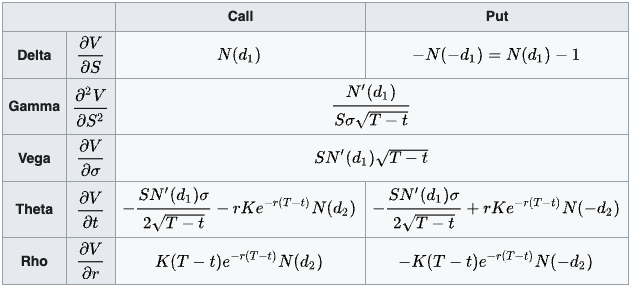

In [ ]:
v0  = [332.1]                       # default
v1  = [212.95]                      # put-call parity added
v2  = [199.9]                       # float to double (CHECK AGAIN with std::expf etc.)                
v3  = [198.25]                      # ... pass by const. reference added (e.g. const float& S) (runtime: -2%)
v4  = [192.3]                       # switch (x / std::sqrt(2.0)) -> x * 0.707...
v5  = [193.65]                      # N_CDF is inline (NO CHANGE)
v6  = [193.05]                      # put & call are inline too (NO CHANGE)
v7  = [191.1]                       # sigma_sqrt_t = sigma * std::sqrt(t) replacement
v8  = [189.2]                       # 0.5* instead of /2.0
v9  = [151.1]                       # std::pow(sigma, 2) --> sigma * sigma
v10 = [149.15]                      # std::exp(-r*t) is global variable (changed in function calls)
v11 = [144.1]                       # exp_min_t_r, sigma_sqrt_t, d_1 are all global
v12 = [143.15]                      # 0.5*(1.0 + ...) = 0.5 + 0.5*...
v13 = [123.05]                      # from std::vector<double> --> static double array
v14 = [120.3]                       # static double array -> global (defined) double array
v15 = [119.6]                       # changed conditions (> --> !=) and order s.t. most likely case comes 1st


# Unattainable
v20 = [39.25]                       # if inline were to be constant

### Idea: Replace costly `N_CDF` function that uses `std::erff` with table-like switch case

In [2]:
quantile_table = dict()

def std_erf(x):
    '''return 0.5 * (1.0 + std::erff(x / std::sqrt(2.0)));'''
    return 0.5+0.5*special.erf(x / np.sqrt(2.0))

In [3]:
# define p grid
p_grid = np.linspace(0.0,1.0,11)
q_grid = np.array([stats.norm.ppf(p_loc, 0, 1) for p_loc in p_grid])
# replace inf 
q_grid[0]  = q_grid[1]  + (q_grid[1] - q_grid[2])
q_grid[-1] = q_grid[-2] + (q_grid[-2] - q_grid[-3])
q_grid

array([-1.7214819 , -1.28155157, -0.84162123, -0.52440051, -0.2533471 ,
        0.        ,  0.2533471 ,  0.52440051,  0.84162123,  1.28155157,
        1.7214819 ])

In [4]:
# compile C++ function body
str_txt = ""
for j, q_loc in enumerate(q_grid):
    if j == 0:
        str_txt += "if(x < {}){{\n    return 0.0;\n}}".format(str(round(q_loc, 5)))
    elif((j != len(q_grid) - 1) and (q_grid[j] < 0)):
        str_txt += "else if(x < {}){{\n    alpha = ((x + {}) / ({} + {}));\n    return alpha*{} + (1-alpha)*{};\n}}".format(str(round(q_loc, 5)), 
                                                                                                                     str(round(-1*q_grid[j], 5)), 
                                                                                                                     str(round(q_grid[j-1], 5)),
                                                                                                                     str(round(-1*q_grid[j], 5)), 
                                                                                                                     str(round(p_grid[j], 5)),
                                                                                                                     str(round(p_grid[j-1], 5)))
    elif((j != len(q_grid) - 1) and (q_grid[j] >= 0)):
        str_txt += "else if(x < {}){{\n    alpha = ((x - {}) / ({} - {}));\n    return alpha*{} + (1-alpha)*{};\n}}".format(str(round(q_loc, 5)), 
                                                                                                                     str(round(q_grid[j], 5)), 
                                                                                                                     str(round(q_grid[j-1], 5)),
                                                                                                                     str(round(q_grid[j], 5)), 
                                                                                                                     str(round(p_grid[j], 5)),
                                                                                                                     str(round(p_grid[j-1], 5)))
    else:
        str_txt += "\nelse{\n    return 1.0;\n}"
        break
# print text
print(str_txt)

if(x < -1.72148){
    return 0.0;
}else if(x < -1.28155){
    alpha = ((x + 1.28155) / (-1.72148 + 1.28155));
    return alpha*0.1 + (1-alpha)*0.0;
}else if(x < -0.84162){
    alpha = ((x + 0.84162) / (-1.28155 + 0.84162));
    return alpha*0.2 + (1-alpha)*0.1;
}else if(x < -0.5244){
    alpha = ((x + 0.5244) / (-0.84162 + 0.5244));
    return alpha*0.3 + (1-alpha)*0.2;
}else if(x < -0.25335){
    alpha = ((x + 0.25335) / (-0.5244 + 0.25335));
    return alpha*0.4 + (1-alpha)*0.3;
}else if(x < 0.0){
    alpha = ((x - 0.0) / (-0.25335 - 0.0));
    return alpha*0.5 + (1-alpha)*0.4;
}else if(x < 0.25335){
    alpha = ((x - 0.25335) / (0.0 - 0.25335));
    return alpha*0.6 + (1-alpha)*0.5;
}else if(x < 0.5244){
    alpha = ((x - 0.5244) / (0.25335 - 0.5244));
    return alpha*0.7 + (1-alpha)*0.6;
}else if(x < 0.84162){
    alpha = ((x - 0.84162) / (0.5244 - 0.84162));
    return alpha*0.8 + (1-alpha)*0.7;
}else if(x < 1.28155){
    alpha = ((x - 1.28155) / (0.84162 - 1.28155));
    return 

In [5]:
# compile Python function body
str_txt = ""
for j, q_loc in enumerate(q_grid):
    if j == 0:
        str_txt += "if(x < {}):\n    return 0.0".format(str(round(q_loc, 5)))
    elif((j != len(q_grid) - 1) and (q_grid[j] < 0)):
        str_txt += "\nelif(x < {}):\n    alpha = ((x + {}) / ({} + {}))\n    return alpha*{} + (1-alpha)*{}".format(str(round(q_loc, 5)), 
                                                                                                                     str(round(-1*q_grid[j], 5)), 
                                                                                                                     str(round(q_grid[j-1], 5)),
                                                                                                                     str(round(-1*q_grid[j], 5)), 
                                                                                                                     str(round(p_grid[j], 5)),
                                                                                                                     str(round(p_grid[j-1], 5)))
    elif((j != len(q_grid) - 1) and (q_grid[j] >= 0)):
        str_txt += "\nelif(x < {}):\n    alpha = ((x - {}) / ({} - {}))\n    return alpha*{} + (1-alpha)*{}".format(str(round(q_loc, 5)), 
                                                                                                                     str(round(q_grid[j], 5)), 
                                                                                                                     str(round(q_grid[j-1], 5)),
                                                                                                                     str(round(q_grid[j], 5)), 
                                                                                                                     str(round(p_grid[j], 5)),
                                                                                                                     str(round(p_grid[j-1], 5)))
    else:
        str_txt += "\nelse:\n    return 1.0"
        break
# print text
print(str_txt)

if(x < -1.72148):
    return 0.0
elif(x < -1.28155):
    alpha = ((x + 1.28155) / (-1.72148 + 1.28155))
    return alpha*0.1 + (1-alpha)*0.0
elif(x < -0.84162):
    alpha = ((x + 0.84162) / (-1.28155 + 0.84162))
    return alpha*0.2 + (1-alpha)*0.1
elif(x < -0.5244):
    alpha = ((x + 0.5244) / (-0.84162 + 0.5244))
    return alpha*0.3 + (1-alpha)*0.2
elif(x < -0.25335):
    alpha = ((x + 0.25335) / (-0.5244 + 0.25335))
    return alpha*0.4 + (1-alpha)*0.3
elif(x < 0.0):
    alpha = ((x - 0.0) / (-0.25335 - 0.0))
    return alpha*0.5 + (1-alpha)*0.4
elif(x < 0.25335):
    alpha = ((x - 0.25335) / (0.0 - 0.25335))
    return alpha*0.6 + (1-alpha)*0.5
elif(x < 0.5244):
    alpha = ((x - 0.5244) / (0.25335 - 0.5244))
    return alpha*0.7 + (1-alpha)*0.6
elif(x < 0.84162):
    alpha = ((x - 0.84162) / (0.5244 - 0.84162))
    return alpha*0.8 + (1-alpha)*0.7
elif(x < 1.28155):
    alpha = ((x - 1.28155) / (0.84162 - 1.28155))
    return alpha*0.9 + (1-alpha)*0.8
else:
    return 1.0


In [8]:
def fake_erf(x):
    if(x < -1.72148):
        return 0.0
    elif(x < -1.28155):
        alpha = ((x + 1.28155) / (-1.72148 + 1.28155))
        return alpha*0.1 + (1-alpha)*0.0
    elif(x < -0.84162):
        alpha = ((x + 0.84162) / (-1.28155 + 0.84162))
        return alpha*0.2 + (1-alpha)*0.1
    elif(x < -0.5244):
        alpha = ((x + 0.5244) / (-0.84162 + 0.5244))
        return alpha*0.3 + (1-alpha)*0.2
    elif(x < -0.25335):
        alpha = ((x + 0.25335) / (-0.5244 + 0.25335))
        return alpha*0.4 + (1-alpha)*0.3
    elif(x < 0.0):
        alpha = ((x - 0.0) / (-0.25335 - 0.0))
        return alpha*0.5 + (1-alpha)*0.4
    elif(x < 0.25335):
        alpha = ((x - 0.25335) / (0.0 - 0.25335))
        return alpha*0.6 + (1-alpha)*0.5
    elif(x < 0.5244):
        alpha = ((x - 0.5244) / (0.25335 - 0.5244))
        return alpha*0.7 + (1-alpha)*0.6
    elif(x < 0.84162):
        alpha = ((x - 0.84162) / (0.5244 - 0.84162))
        return alpha*0.8 + (1-alpha)*0.7
    elif(x < 1.28155):
        alpha = ((x - 1.28155) / (0.84162 - 1.28155))
        return alpha*0.9 + (1-alpha)*0.8
    else:
        return 1.0


In [19]:
# Compare the two
print('Approximation fake_erf(x)=', round(fake_erf(0.2), 4), ', Groundtruth erf(x)=', round(std_erf(0.2), 4))

print('abs. error: ', round(abs(fake_erf(0.2) - std_erf(0.2)), 3))

Approximation fake_erf(x)= 0.5211 , Groundtruth erf(x)= 0.5793
abs. error:  0.058


In [21]:
# Check global performance (trivially)
f_vals = [np.abs(fake_erf(x_loc) - std_erf(x_loc)) for x_loc in np.linspace(0.0,1.0,1001)]
print('Max difference: ', round(max(f_vals), 4))

Max difference:  0.1
